# Fit regression with auto-sklearn


Follow the simple example at [this link](https://automl.github.io/auto-sklearn/master/examples/20_basic/example_regression.html#sphx-glr-examples-20-basic-example-regression-py) for a regression task.

## Load data

In [1]:
import pandas as pd
data = pd.read_csv("FullData.csv", index_col=0)
data.drop(columns="X.name", inplace=True)
# separate features from target.
y = data.pop("z")
X = data 

* Feature matrix

In [3]:
X.shape

(1444, 11)

* Target for regression

In [4]:
y.shape

(1444,)

* Split train and test sets

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

We leave a test set for the final evaluation of the best ensemble model. The test set is 30% of the

In [5]:
X_train.shape[0]/X_test.shape[0]

3.0

## Run auto-ml for regression

In [6]:
import autosklearn.regression

A vanilla ensemble regressor where we only specify limits for the time each task should take. The regressor list can be seen as well

In [7]:
from autosklearn.pipeline.components.regression import RegressorChoice

for name in RegressorChoice.get_components():
    print(name)

adaboost
ard_regression
decision_tree
extra_trees
gaussian_process
gradient_boosting
k_nearest_neighbors
liblinear_svr
libsvm_svr
mlp
random_forest
sgd


The default preprocessing steps are used and the default resampling strategy is used (a holdout set with training fraction of 0.67) (see [this example](https://automl.github.io/auto-sklearn/master/examples/40_advanced/example_resampling.html#sphx-glr-examples-40-advanced-example-resampling-py) for different resampling strategies).

In [8]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder='/tmp/autosklearn_regression_vanilla_agn',
)
automl.fit(X_train, y_train, dataset_name='agn')

AutoSklearnRegressor(per_run_time_limit=30, time_left_for_this_task=120,
                     tmp_folder='/tmp/autosklearn_regression_vanilla_agn')

We can print the best models in the ensemble

In [9]:
print(automl.leaderboard())

          rank  ensemble_weight              type      cost  duration
model_id                                                             
8            1             0.28  gaussian_process  0.435638  3.318596
14           2             0.20    ard_regression  0.444250  0.440273
2            3             0.32     random_forest  0.447033  2.472736
15           4             0.20               sgd  0.453555  0.467454


And we can see how the individual models are built

In [10]:
print(automl.show_models())

[(0.320000, SimpleRegressionPipeline({'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'no_preprocessing', 'regressor:__choice__': 'random_forest', 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'standardize', 'regressor:random_forest:bootstrap': 'True', 'regressor:random_forest:criterion': 'mse', 'regressor:random_forest:max_depth': 'None', 'regressor:random_forest:max_features': 1.0, 'regressor:random_forest:max_leaf_nodes': 'None', 'regressor:random_forest:min_impurity_decrease': 0.0, 'regressor:random_forest:min_samples_leaf': 1, 'regressor:random_forest:min_samples_split': 2, 'regressor:random_forest:min_weight_fracti

And the summary of the models

In [30]:
print(automl.sprint_statistics())

auto-sklearn results:
  Dataset name: agn
  Metric: r2
  Best validation score: 0.564362
  Number of target algorithm runs: 27
  Number of successful target algorithm runs: 21
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 2
  Number of target algorithms that exceeded the memory limit: 4



And we can see all the individual results too

In [ ]:
results = pd.DataFrame(automl.cv_results_)
results.head()

From the summary above we know that the default metric for a regression task is the R2 score. We can change it to optimize the RMSE for example.

<AxesSubplot:xlabel='rank_test_scores', ylabel='mean_test_score'>

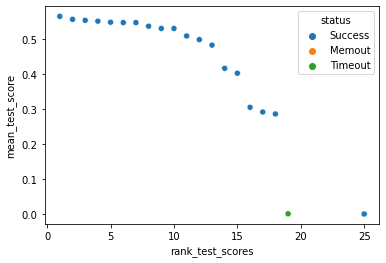

In [13]:
import seaborn as sns

sns.scatterplot(x="rank_test_scores", y="mean_test_score", hue="status", data=results)

In [17]:
results.loc[0,"params"]

{'data_preprocessor:__choice__': 'feature_type',
 'feature_preprocessor:__choice__': 'no_preprocessing',
 'regressor:__choice__': 'random_forest',
 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'mean',
 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'standardize',
 'regressor:random_forest:bootstrap': 'True',
 'regressor:random_forest:criterion': 'mse',
 'regressor:random_forest:max_depth': 'None',
 'regressor:random_forest:max_features': 1.0,
 'regressor:random_forest:max_leaf_nodes': 'None',
 'regressor:random_forest:min_impurity_decrease': 0.0,
 'regressor:random_forest:min_samples_leaf': 1,
 'regressor:random_forest:min_samples_split': 2,
 'regressor:random_forest:min_weight_fraction_leaf': 0.0,
 'data_

## Score

In [18]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

Refit the estimator using the entire training dataset

In [23]:
print('After re-fit')
automl.refit(X_train.copy(), y_train.copy())

After re-fit


AutoSklearnRegressor(per_run_time_limit=30, time_left_for_this_task=120,
                     tmp_folder='/tmp/autosklearn_regression_vanilla_agn')

In [24]:
train_predictions = automl.predict(X_train)
test_predictions = automl.predict(X_test)

In [25]:
print("Train R2 score:", r2_score(y_train, train_predictions))
print("Test R2 score:", r2_score(y_test, test_predictions))

Train R2 score: 0.7123552416406556
Test R2 score: 0.4953384129329148


In [26]:
print("Train MAE score:", mean_absolute_error(y_train, train_predictions))
print("Test MAE score:", mean_absolute_error(y_test, test_predictions))

Train MAE score: 0.2533369841455849
Test MAE score: 0.3215827071121787


In [27]:
import numpy as np 

print("Train RMSE score:", np.sqrt(mean_squared_error(y_train, train_predictions)))
print("Test RMSE score:", np.sqrt(mean_squared_error(y_test, test_predictions)))

Train RMSE score: 0.35458653280409985
Test RMSE score: 0.4844641762429633


# Plot predictions

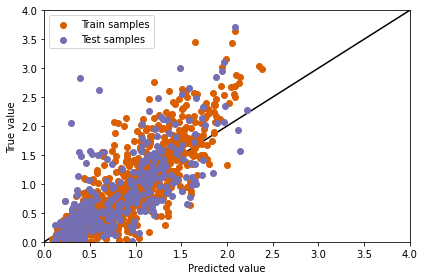

In [29]:
from matplotlib import pyplot as plt 

plt.scatter(train_predictions, y_train, label="Train samples", c='#d95f02')
plt.scatter(test_predictions, y_test, label="Test samples", c='#7570b3')
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.plot([0, 4], [0, 4], c='k', zorder=0)
plt.xlim([0, 4])
plt.ylim([0, 4])
plt.tight_layout()
plt.show()